In [1]:
from pulp import *
import utils

In [2]:
WIDTH = 0
HEIGHT = 1

In [3]:
def run_LP(w, n, dims, rotation):    
    upper_bound = sum(dims[:, HEIGHT])
    k = 4
    prob = LpProblem("VLSI", LpMinimize)
    L = LpVariable("L", 0, upper_bound, LpInteger)
    pos_x = LpVariable.dicts("pos_x", range(n), 0, w, LpInteger)
    pos_y = LpVariable.dicts("pos_y", range(n), 0, upper_bound, LpInteger)
    M0 = M1 = w
    M2 = M3 = upper_bound
    pos_chosen = LpVariable.dict("pos_chosen", (range(n), range(n), range(k)), 0, 1, LpInteger)
    rotated = LpVariable.dict("rotated", range(n), 0, 1, LpInteger)
    prob += L

    if rotation:
        for i in range(n):
            prob += L >= pos_y[i] + dims[i, HEIGHT]*(1-rotated[i])+ rotated[i]*dims[i, WIDTH]
            for j in range(i + 1, n):
                prob += pos_x[i] + (1-rotated[i])*dims[i, WIDTH] + rotated[i]*dims[i, HEIGHT]<= pos_x[j] + M0 * (pos_chosen[i, j, 0])
                prob += pos_x[j] + (1-rotated[j])*dims[j, WIDTH] + rotated[j]*dims[j, HEIGHT] <= pos_x[i] + M1 * (pos_chosen[i, j, 1])
                prob += pos_y[i] + (1-rotated[i])*dims[i, HEIGHT] + rotated[i]*dims[i, WIDTH]<= pos_y[j] + M2 * (pos_chosen[i, j, 2])
                prob += pos_y[j] + (1-rotated[j])*dims[j, HEIGHT] + rotated[j]*dims[j, WIDTH]<= pos_y[i] + M3 * (pos_chosen[i, j, 3])
                prob += lpSum([pos_chosen[i, j, k] for k in range(k)]) <= 3

        prob += pos_x[n-1] + (1-rotated[n-1])*dims[n-1, WIDTH] + rotated[n-1]*dims[n-1, HEIGHT] <= M1  

    if not rotation:
        for i in range(n):
            prob += L >= pos_y[i] + dims[i, HEIGHT]
            for j in range(i + 1, n):
                prob += pos_x[i] + dims[i, WIDTH] <= pos_x[j] + M0 * pos_chosen[i, j, 0]
                prob += pos_x[j] + dims[j, WIDTH] <= pos_x[i] + M1 * pos_chosen[i, j, 1]
                prob += pos_y[i] + dims[i, HEIGHT] <= pos_y[j] + M2 * pos_chosen[i, j, 2]
                prob += pos_y[j] + dims[j, HEIGHT] <= pos_y[i] + M3 * pos_chosen[i, j, 3]
                prob += lpSum([pos_chosen[i, j, k] for k in range(k)]) <= k - 1

    status = prob.solve()
    LpStatus[status]

    print(f"value of L: {value(L)}")
    sol = []
    sol.append([w, value(L)])
    sol.append([n])
    for i in range(n):
        print(i)
        
        width = dims[i, int(value(rotated[i]))]
        height = dims[i, 1-int(value(rotated[i]))]
        
        sol.append([width, height, int(value(pos_x[i])), int(value(pos_y[i]))])
        print(value(pos_x[i]), value(pos_y[i]))
    return sol, prob

In [8]:
INSTANCE_NUMBER = 2
ALL_SOLUTIONS = False
ROTATION = True

solutions = []
for i in range(1,4):
    file_path = f"../instances/ins-{i}.txt"
    w, n, dims = utils.read_output(file_path)
    sol, prob = run_LP(w,n, dims, ROTATION)
    solutions.append(sol)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/t4/vnxj6kkj2n97knry5lnrscx00000gn/T/80e93391baf248db831543c82697a721-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/t4/vnxj6kkj2n97knry5lnrscx00000gn/T/80e93391baf248db831543c82697a721-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 40 COLUMNS
At line 250 RHS
At line 286 BOUNDS
At line 324 ENDATA
Problem MODEL has 35 rows, 37 columns and 119 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5 - 0.00 seconds
Cgl0004I processed model has 34 rows, 35 columns (35 integer (26 of which binary)) and 118 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 24 integers unsatisfied sum - 7.5
Cbc0038I Pass   1: suminf.    3.75000 (11) obj. 8 iterations 12
Cbc

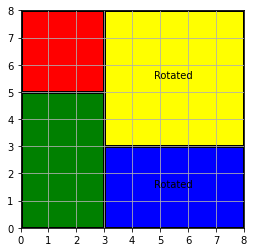

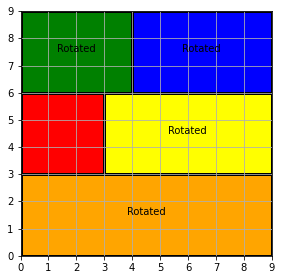

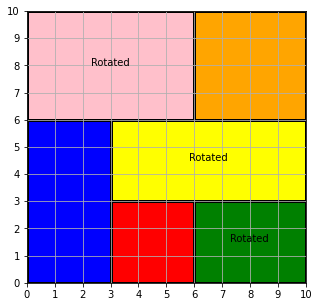

In [9]:
for sol in solutions:   
    v = utils.visualize_output(sol, dims)